In [215]:
#-- Modules & Packages

import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# import python_ta as ta
import ta as ta
from technical_features_indicators import moving_yngzng_estimator
from technical_features_indicators import kaufman_ad_movavg
from technical_features_indicators import kama_mkt_regime
from technical_features_indicators import vwap


from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

Data Collecting.

In [260]:
ticker = ['LTC-USD']

#-- Collecting 3 years
start_date = date.today() + relativedelta(months = - 36)
end_date = date.today()

#-- 1D ohlcv data collection
df_asset = yf.download(ticker, start_date, end_date, interval = '1D')

#-- Dropping irrelevant columns
df_asset.drop(columns=['Adj Close'], axis = 1, inplace=True)

#-- Converting all column names to lowercase
df_asset.columns = [x.lower() for x in df_asset.columns ]

#-- Previewing
df_asset

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2021-04-03,213.159744,218.240234,197.146210,197.148209,4020429578
2021-04-04,197.109772,206.219879,195.534042,204.042908,2866830149
2021-04-05,204.047775,225.400848,200.928452,221.069046,4789647554
2021-04-06,221.614639,244.517471,217.633453,237.664902,9267495720
2021-04-07,237.561569,243.151276,212.226654,219.423676,8711169124
...,...,...,...,...,...
2024-03-29,94.219017,110.005928,93.110497,109.258972,1803906237
2024-03-30,109.243942,109.249985,101.306541,102.863113,729886796
2024-03-31,102.866302,106.548813,101.554459,105.183403,638798519


Features & Indicators.

In [261]:
df_asset = kaufman_ad_movavg(df_asset, 'close', 5)
df_asset = kama_mkt_regime(df_asset, 'close', 5, 15)
df_asset = vwap(df_asset)

In [262]:
df_asset['next_candle'] = df_asset['close'].shift(-1)
df_asset['target'] = (df_asset['next_candle'] > df_asset['close']).astype(int)


In [263]:
df_asset

,open,high,low,close,volume,kama_5,kama_15,kama_diff,mkt_trend,volXclose,cum_vol,cum_volXclose,vwap,next_candle,target
Date,,,,,,,,,,,,,,,
2021-04-03,213.159744,218.240234,197.146210,197.148209,4020429578,NaN,NaN,NaN,-1,7.926205e+11,4020429578,8.774195e+11,218.240234,204.042908,1
2021-04-04,197.109772,206.219879,195.534042,204.042908,2866830149,NaN,NaN,NaN,-1,5.849564e+11,6887259727,1.468617e+12,213.236747,221.069046,1
2021-04-05,204.047775,225.400848,200.928452,221.069046,4789647554,NaN,NaN,NaN,-1,1.058843e+12,11676907281,2.548207e+12,218.226232,237.664902,1
2021-04-06,221.614639,244.517471,217.633453,237.664902,9267495720,NaN,NaN,NaN,-1,2.202558e+12,20944403001,4.814272e+12,229.859600,219.423676,0
2021-04-07,237.561569,243.151276,212.226654,219.423676,8711169124,219.423676,NaN,NaN,-1,1.911437e+12,29655572125,6.932404e+12,233.763960,227.003021,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-29,94.219017,110.005928,93.110497,109.258972,1803906237,96.690671,90.324380,-6.366291,-1,1.970929e+11,1381425115856,2.533534e+14,183.400001,102.863113,0
2024-03-30,109.243942,109.249985,101.306541,102.863113,729886796,97.298920,90.775137,-6.523783,-1,7.507843e+10,1382155002652,2.534331e+14,183.360844,105.183403,1
2024-03-31,102.866302,106.548813,101.554459,105.183403,638798519,97.901090,91.869177,-6.031913,-1,6.719100e+10,1382793801171,2.535012e+14,183.325359,99.375343,0


In [264]:
from sklearn.ensemble import RandomForestClassifier

#-- dropping nan rows to avoid issues with fit() function
df_asset.dropna(inplace = True)

model = RandomForestClassifier(n_estimators = 30, min_samples_split= 100, random_state= 1)
train_df = df_asset[:-200]
test_df = df_asset[-200:]


predictors = ['close', 'open', 'high', 'low','mkt_trend', 'kama_diff' ]
model.fit(train_df[predictors], train_df['target'])

RandomForestClassifier(min_samples_split=100, n_estimators=30, random_state=1)

In [265]:
from sklearn.metrics import precision_score

predictions = model.predict(test_df[predictors])
predictions = pd.Series(predictions, index = test_df.index)
precision_score(test_df['target'], predictions)

0.5477707006369427

<AxesSubplot: xlabel='Date'>

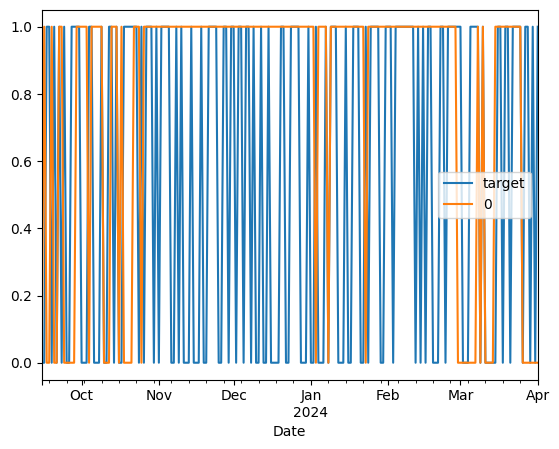

In [266]:
combined = pd.concat([test_df['target'], predictions], axis = 1)
combined.plot()

In [267]:
def predict(train_df, test_df, predictors, model):
    model.fit(train_df[predictors], train_df['target'])
    predictions = model.predict(test_df[predictors])
    predictions = pd.Series(predictions, index = test_df.index, name = "predictions")
    combined = pd.concat([test_df['target'], predictions], axis =1)
    return combined

def backtest(data, model, predictors, start = 90, step = 7):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train_df = data.iloc[0:i].copy()
        test_df = data.iloc[i:(i + step)].copy()
        predictions = predict(train_df, test_df, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
    # return all_predictions

In [268]:
df_asset.head(3)

,open,high,low,close,volume,kama_5,kama_15,kama_diff,mkt_trend,volXclose,cum_vol,cum_volXclose,vwap,next_candle,target
Date,,,,,,,,,,,,,,,
2021-04-17,309.556641,335.024536,300.613129,304.759918,13254117896,279.916349,304.759918,24.843569,1,4.039324e+12,102717955042,2.782884e+13,270.924760,273.098816,0
2021-04-18,304.647034,307.304260,238.337418,273.098816,13129808269,279.833990,302.410567,22.576577,1,3.585735e+12,115847763311,3.186368e+13,275.047894,261.919220,0
2021-04-19,273.645142,281.352539,251.514481,261.919220,9384818110,279.121263,300.452492,21.331229,1,2.458064e+12,125232581421,3.450413e+13,275.520359,260.941345,0


In [269]:
#-- dropping nan rows to avoid issues with backtest function
df_asset.dropna(inplace=True)

pred_x = ['close','mkt_trend','kama_5','kama_15']

predictions = backtest(df_asset, model, predictors=pred_x)

In [270]:
predictions

,target,predictions
Date,,
2021-07-16,0,0
2021-07-17,0,0
2021-07-18,0,0
2021-07-19,0,0
2021-07-20,1,0
...,...,...
2024-03-28,1,0
2024-03-29,0,0
2024-03-30,1,0


In [271]:
predictions['predictions'].value_counts()
precision_score(predictions['target'], predictions['predictions'])
print("Our initial model has a precision score of:", round(100 * (precision_score(predictions['target'], predictions['predictions'])),2),"%.")


0.531615925058548

In [272]:
predictions['target'].value_counts() / predictions.shape[0]

1    0.520686
0    0.479314
Name: target, dtype: float64

Adding rolling averages on different lookback windows.

In [279]:

lookbacks = [3,7,60,365]

for lookback in lookbacks:
    #-- set center = False to avoid look ahead leaks
    rolling_avg = df_asset.rolling(lookback, center=False).mean()
    ratio_column = f"closeprice_ratio_{lookback}"
    df_asset[ratio_column] = df_asset["close"] / rolling_avg['close']
    trend_column = f"trend_{lookback}"
    df_asset[trend_column] = df_asset.shift(1).rolling(lookback).sum()['target']

#-- previewing dataset so far
df_asset.head(3)

,open,high,low,close,volume,kama_5,kama_15,kama_diff,mkt_trend,volXclose,...,next_candle,target,closeprice_ratio_3,trend_3,closeprice_ratio_7,trend_7,closeprice_ratio_60,trend_60,closeprice_ratio_365,trend_365
Date,,,,,,,,,,,,,,,,,,,,,
2022-04-17,114.404831,114.969009,108.763725,109.042786,673093200,112.546176,115.648014,3.101837,1,7.339596e+10,...,111.226143,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-18,109.035522,111.325768,105.704910,111.226143,810603033,112.535515,115.383150,2.847635,1,9.016025e+10,...,113.812088,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-19,111.229103,113.990005,110.827805,113.812088,653731832,112.642069,115.332351,2.690282,1,7.440258e+10,...,111.979691,0,1.022016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [275]:
#-- dropping rows with nan values before running backtest with model
df_asset.dropna(inplace=True)

# pred_x = ['close', 'trend_3','trend_7','trend_60','trend_365'] # better 2 % for XMR-USDT
pred_x = ['close', 'trend_3','trend_7','trend_60','trend_365','closeprice_ratio_3','closeprice_ratio_7','closeprice_ratio_60'] # better 3 % for XMR-USDT

predictions_b = backtest(df_asset, model, predictors=pred_x)

predictions_b['predictions'].value_counts()
precision_score(predictions_b['target'], predictions_b['predictions'])

print("After computing and adding moving averages to better catch trend, our model shows a precision score of:", round(100 * (precision_score(predictions_b['target'], predictions_b['predictions'])),2),"%.")


After computing and adding moving averages to better catch trend, our model shows a precision score of: 54.58 %.


Improved Model

In [276]:

# def predict_bis(train_df, test_df, predictors, model_b):
#     model_b.fit(train_df[predictors], train_df["target"])
#     preds = model_b.predict_proba(test_df[[predictors]])[:,1]
#     preds[preds >=.6] = 1
#     preds[preds < 0.6] = 0
#     preds = pd.Series(preds, index = test_df.index, name = 'predicitions')
#     combined = pd.concat([test_df['target'], preds], axis = 1)
#     return combined


In [277]:
model_b = RandomForestClassifier(n_estimators=200, min_samples_split=100, random_state=1)
#-- reassigning optimal predictors to new variable best_predictors
best_predictors = ['close', 'trend_3','trend_7','trend_60','trend_365','closeprice_ratio_3','closeprice_ratio_7','closeprice_ratio_60']

predictions_final = backtest(df_asset, model_b, best_predictors)

predictions_final['predictions'].value_counts()

0    356
1    270
Name: predictions, dtype: int64

In [278]:
print("The improved model has a precision score of:", round(100 * (precision_score(predictions_final['target'], predictions_final['predictions'])),2),"%.")

The improved model has a precision score of: 56.67 %.
